In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import kgbench as kg
import fire, sys
import math

from kgbench import load, tic, toc, d


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


#
from torch_geometric.utils import to_networkx
import networkx as nx

from src.rgcn_explainer_utils import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from rgcn_model import RGCN

In [2]:

def convert_binary(sparse_tensor, threshold):
    # convert values to either 0 or 1 based on a threshold of 0.5
    mask = sparse_tensor._values() > threshold
    converted_values = torch.zeros_like(sparse_tensor._values())
    converted_values[mask] = 1

    # create a new sparse tensor with the converted values
    converted_sparse_tensor = torch.sparse_coo_tensor(sparse_tensor._indices(), converted_values, size=sparse_tensor.size())
    return converted_sparse_tensor

In [82]:
data = kg.load('mdgenre', torch=True)
model = torch.load('chk/mdgenre_chk/model_mdgenre_prune_False')

loaded data mdgenre (78.89s).


In [106]:
v = torch.sparse_coo_tensor(v.coalesce().indices(), torch.sigmoid(v.coalesce().values()), v.size(), requires_grad=True)
v

tensor(indices=tensor([[ 88538, 196243, 229383, 328803],
                       [     0,   1579,      0,   5230]]),
       values=tensor([0.9762, 0.5834, 0.9767, 0.5713]),
       size=(753935, 8285), nnz=4, layout=torch.sparse_coo, requires_grad=True)

In [233]:
name = 'aifb'
if name == 'aifb':
    data = kg.load('aifb', torch=True) 
    print(data.triples.shape[0])
    node_idx = 5757

else:
    data = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/data/IMDB/finals/{name}.pt')

data = prunee(data, 2)
print(data.triples.shape[0])
data.triples = torch.Tensor(data.triples).to(int)#data.triples.clone().detach()
data.withheld = torch.Tensor(data.withheld).to(int)#data.withheld.clone().detach()
data.training = torch.Tensor(data.training).to(int)#data.training.clone().detach()
#
# get_relations(data)
# d_classes(data)
dict_classes = {key.item(): data.withheld[:, 0][data.withheld[:, 1] == key].tolist() for key in torch.unique(data.withheld[:, 1])}
if name != 'aifb':
    node_idx = dict_classes[0][0]


from src.rgcn_explainer_utils import *
v = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/size_0.005_lr_0.1_epochs_30_threshold_0.5_init_overall_frequency/masked_adj/masked_ver{node_idx}')
h = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/size_0.005_lr_0.1_epochs_30_threshold_0.5_init_overall_frequency/masked_adj/masked_hor{node_idx}')
# h = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/masked_adj/masked_hor{node_idx}_new')
# v = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/masked_adj/masked_ver{node_idx}_new')
model = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/model_{name}_prune_True')

# v = torch.sparse_coo_tensor(v.coalesce().indices(), torch.sigmoid(v.coalesce().values()), v.size(), requires_grad=True)
# h = torch.sparse_coo_tensor(h.coalesce().indices(), torch.sigmoid(h.coalesce().values()), h.size(), requires_grad=True)
out = model.forward2(h,v)

res = nn.Softmax(dim=0)(out[node_idx])
print('ypred explain', res)
print(v.coalesce().values()[v.coalesce().values()>0.5])
print(h.coalesce().values())

v,h = convert_binary(v, 0.8), convert_binary(h,0.8)
print('v binary:',v)
res = nn.Softmax(dim=0)(model.forward2(h,v)[node_idx, :])
print('ypred explain binary', res)

if node_idx in data.withheld[:,0]:
    print('ypred true', data.withheld[data.withheld[:,0]==node_idx,1])
    
from r_exp import hor_ver_graph
model.eval()
hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
y_full = model.forward2(hor_graph, ver_graph)
node_pred_full = y_full[node_idx, :]
res_full = nn.Softmax(dim=0)(node_pred_full)
print('ypred full', res_full)

loaded data aifb (0.2425s).
29043
26666
ypred explain tensor([0.2647, 0.2476, 0.3399, 0.1478], grad_fn=<SoftmaxBackward0>)
tensor([0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738,
        0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738,
        0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738,
        0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738,
        0.6738, 0.6738, 0.6738, 0.6738, 0.6738, 0.6738])
tensor([0.3945, 0.3945, 0.3945,  ..., 0.3945, 0.3945, 0.3945])
non zero: 0
non zero: 0
v binary: tensor(indices=tensor([[ 88607, 196312, 229452,  ..., 329925, 329926, 329927],
                       [   908,   2227,   1002,  ...,   5230,   5230,   5230]]),
       values=tensor([0., 0., 0.,  ..., 0., 0., 0.]),
       size=(753935, 8285), nnz=1090, layout=torch.sparse_coo)
ypred explain binary tensor([0.2730, 0.2465, 0.2477, 0.2329], grad_fn=<SoftmaxBackward0>)
ypred true tensor([2])


RGCN()

ypred full tensor([4.2013e-07, 1.4282e-06, 1.0000e+00, 6.0994e-09],
       grad_fn=<SoftmaxBackward0>)


In [234]:
data.i2r[39]

'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'

In [180]:
#get the node of the most important relations - the relations with the highest weights

tensor_list = (list(v.coalesce().indices()[1][v.coalesce().values()>0.5]) + list(h.coalesce().indices()[0][h.coalesce().values()>0.5]))
float_list = [tensor.item() for tensor in tensor_list]
len(set(float_list))


11

In [159]:
from src.rgcn_explainer_utils import find_n_hop_neighbors, edge_index_oneadj

data = kg.load('aifb', torch=True) 
#data = prunee(data, 2)
a_l,n, a = find_n_hop_neighbors( edge_index_oneadj(data.triples), 2, 5757)
len(a_l)
len(set(n))

loaded data aifb (0.2127s).


1601

1171

In [169]:
def find_n_hop_neighbors(edge_index, n, node=None):
    """ 
    edge_index 
    n = num hops
    node = node_idx
    returns: 
        - sub_edges: list of edges in the n-hop neighborhood of the specified node
        - neighborhoods: dictionary of node neighborhoods
        - sub_edges: tensor of edges in the n-hop neighborhood of the specified node

    """
    # create dictionary of node neighborhoods
    neighborhoods = {}
    for i in range(edge_index.max().item() + 1):
        neighborhoods[i] = set()

    # find 1-hop neighbors and corresponding edges
    edges = []
    for j in range(edge_index.shape[1]):
        src, dst = edge_index[0, j].item(), edge_index[1, j].item()
        neighborhoods[src].add(dst)
        neighborhoods[dst].add(src)
        edges.append((src, dst))

    # find n-hop neighbors for the specified node or all nodes

    for k in range(2, n+1):
        new_neighbors = set()
        for neighbor in neighborhoods[node]:
            new_neighbors.update(neighborhoods[neighbor])
        neighborhoods[node].update(new_neighbors)
    sub_edges = []
    for edge in edges:
        src, dst = edge
        if src in neighborhoods[node] and dst in neighborhoods[node] or src == node or dst == node:
            sub_edges.append(edge)
            
    sub_edges_tensor = torch.tensor([sub_edges[i] for i in range(len(sub_edges))]).t()        

    #return {node: sub_edges}, {node: neighborhoods[node]}, sub_edges_tensor
    return sub_edges, neighborhoods[node], sub_edges_tensor  
sub_edges, neighborhoods, sub_edges_tensor  = find_n_hop_neighbors(edge_index_oneadj(data.triples),2, 5857)

In [170]:
len(sub_edges)

2225

In [161]:
count = 0
others = []
for i in data.triples:

    if i[0] == 5857:
        print(i)
        count += 1
        others.append(i[2])
    if i[2] == 5857:
        print(i)
        count += 1
        others.append(i[0])

count
others

tensor([5388,   18, 5857])
tensor([5505,   21, 5857])
tensor([5857,   10,    0])
tensor([5857,   23, 4559])
tensor([5857,   27,    0])
tensor([5857,   28, 5637])
tensor([5857,   30, 6894])
tensor([5857,   30, 6949])
tensor([5857,   30, 7140])
tensor([5857,   30, 7142])
tensor([5857,   30, 7258])
tensor([5857,   30, 7892])
tensor([5857,   36, 5917])
tensor([5857,   36, 5935])
tensor([5857,   39, 5230])
tensor([5857,   39, 5231])
tensor([5917,   21, 5857])
tensor([5935,   21, 5857])
tensor([5967,   21, 5857])
tensor([6894,    2, 5857])
tensor([6949,    2, 5857])
tensor([7140,    2, 5857])
tensor([7142,    2, 5857])
tensor([7258,    2, 5857])
tensor([7892,    2, 5857])


25

[tensor(5388),
 tensor(5505),
 tensor(0),
 tensor(4559),
 tensor(0),
 tensor(5637),
 tensor(6894),
 tensor(6949),
 tensor(7140),
 tensor(7142),
 tensor(7258),
 tensor(7892),
 tensor(5917),
 tensor(5935),
 tensor(5230),
 tensor(5231),
 tensor(5917),
 tensor(5935),
 tensor(5967),
 tensor(6894),
 tensor(6949),
 tensor(7140),
 tensor(7142),
 tensor(7258),
 tensor(7892)]

In [160]:
count = 0
l = []
a = []
for i in data.triples:
    for n in others:
        if i[0] == int(n) or i[2] == int(n):
            count += 1
            l.append(n)
            a.append(i)
            #print(i)
            break
res = set(l)
resa = set(a)
print(len(resa))            
print(len(res))
count
#others

1343
14


1343

In [72]:
def find_repeating_sublists(sublists):
    repeating_elements = {}

    for sublist in sublists:
        key1 = (sublist[0], sublist[2])
        key2 = (sublist[2], sublist[0])

        if key1 in repeating_elements:
            repeating_elements[key1].append(sublist[1])
        elif key2 in repeating_elements:
            repeating_elements[key2].append(sublist[1])
        else:
            repeating_elements[key1] = [sublist[1]]

    result_array = []
    for key, values in repeating_elements.items():
        if len(values) > 1:
            result_array.append([key[0], values, key[1]])
        else:
            result_array.append([key[0], [values[0]], key[1]])

    return result_array

def unnest_list(nested_list):
    return [item for sublist in nested_list for item in (unnest_list(sublist) if isinstance(sublist, list) else [sublist])]

def visualize(node_idx, n_hop, data, masked_ver,threshold,name, result_weights=True, low_threshold=False ):
    """ 
    Visualize important nodes for node idx prediction
    """
    dict_index = dict_index_classes(data,masked_ver)
    
    #select only nodes with a certain threshold
    sel_masked_ver = sub_sparse_tensor(masked_ver, threshold,data, low_threshold)
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    print('sel masked ver',sel_masked_ver)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) #original edge indexes

    
    
    G = nx.Graph()
    if result_weights:
        values = sel_masked_ver.coalesce().values().detach().numpy()
        for s,p,o in zip(indices_nodes[0],values , indices_nodes[1]):
            G.add_edge(int(s), int(o), weight=np.round(p, 2))

    else:

        triples_matched = match_to_triples(sel_masked_ver, data)
        l = []
        for i in triples_matched[:,1]:
            l.append(data.i2rel[int(i)][0])
        triples_matched = find_repeating_sublists(triples_matched.numpy())
        for s,p,o in triples_matched:
            G.add_edge(int(s), int(o), weight=p)


    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    
    weights = [[item] if not isinstance(item, list) else item for item in weights]


    pos = nx.circular_layout(G)

    ordered_dict = {}
    for item in list(G.nodes):
        if item in ordered_dict:
            ordered_dict[item].append(dict_index[item])
        else:
            ordered_dict[item] =  dict_index[item]

    dict_index = ordered_dict

    labeldict = {}
    for node in G.nodes:
        labeldict[int(node)] = int(node)  


    dict = {}
    for k,v in dict_index.items():
        for k1,v1 in data.entities_classes.items():
            if v==k1: 

                dict[k] = v1
            else:
                if k not in dict:
                    dict[k] = 0
                

    color_list = list(dict.values())
    color_list = list(encode_dict(dict_index).values())


    col_weights = [weights[i][0] for i in range(len(weights))]
    if result_weights:
        
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=col_weights, node_color =  color_list, cmap="Set2",edge_cmap=plt.cm.Reds,font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(weights)
        cbar = plt.colorbar(sm)
        cbar.ax.set_title('Weight')
        plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, n_hop))
    else:
        rel = nx.get_edge_attributes(G,'weight')
        rel = {k: [data.i2rel[i][0] for i in v] for k,v in rel.items()}
        col_weights = [sum(weights[i], 3) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict, edge_color=col_weights,edgelist=edges,node_color =  color_list, cmap="Set2",font_size=7, arrows = True)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=8,font_color='red')
        
        res = Counter(unnest_list(rel.values()))
    if result_weights:
        if not os.path.exists(f'chk/{name}_chk/graphs'):
            os.makedirs(f'chk/{name}_chk/graphs')  
        plt.savefig(f'chk/{name}_chk/graphs/Explanation_{node_idx}_{n_hop}_weights.png')

        #plt.show()

    else:
        if not os.path.exists(f'chk/{name}_chk/graphs'):
            os.makedirs(f'chk/{name}_chk/graphs')  
        plt.savefig(f'chk/{name}_chk/graphs/Explanation_{node_idx}_{n_hop}_relations.png')    
        #plt.show()
        return res, weights
    

sel masked ver tensor(indices=tensor([[6860, 6874, 6920, 6976, 7731, 7837, 7857, 7905, 7933,
                        7973, 5757, 5757, 5757, 5757, 5757, 5757, 5757, 5757,
                        5757, 5757, 5757, 5757, 5757, 5757],
                       [5757, 5757, 5757, 5757, 5757, 5757, 5757, 5757, 5757,
                        5757,  908, 2227, 1002, 6860, 6874, 6920, 6976, 7731,
                        7837, 7857, 7905, 7933, 7973, 5230]]),
       values=tensor([0.9269, 0.9225, 0.9169, 0.2052, 0.9149, 0.2027, 0.9077,
                      0.2068, 0.9123, 0.1876, 0.1826, 0.9114, 0.2000, 0.9098,
                      0.2027, 0.9020, 0.1819, 0.1815, 0.9160, 0.1857, 0.1849,
                      0.9072, 0.1921, 0.9121]),
       size=(7974, 7974), nnz=24, layout=torch.sparse_coo)


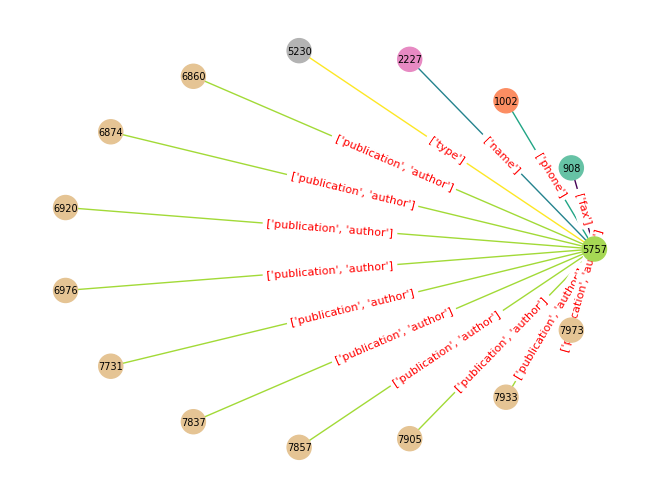

In [74]:

v = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/masked_adj/masked_ver{node_idx}_new')
res, weights = visualize(node_idx, 2, data, v, 0, name, result_weights=False, low_threshold=False)

In [192]:
import torch

def hor_ver_graph(triples, n, r):
    """
    input: triples, number of nodes, number of relations
    output: hor_graph, ver_graph : horizontally and vertically stacked adjacency matrix
    """

    hor_ind, hor_size = adj(triples, n, 2*r+1, vertical=False)
    ver_ind, ver_size = adj(triples, n, 2*r+1, vertical=True)

    rn, _ = hor_size  # horizontally stacked adjacency matrix size
    r = rn // n  # number of relations enriched divided by number of nodes

    vals = torch.ones(ver_ind.size(0), dtype=torch.float)  # number of enriched triples

    hor_graph = torch.sparse.FloatTensor(hor_ind.t(), vals, hor_size)  # size: n, r, emb
    ver_graph = torch.sparse.FloatTensor(ver_ind.t(), vals, ver_size)

    return hor_graph, ver_graph

def adj(triples, num_nodes, num_rels, cuda=False, vertical=True):
    """
     Computes a sparse adjacency matrix for the given graph (the adjacency matrices of all
     relations are stacked vertically).

     :param edges: List representing the triples
     :param i2r: list of relations
     :param i2n: list of nodes
     :return: sparse tensor
    """
    r, n = num_rels, num_nodes
    size = (r * n, n) if vertical else (n, r * n)

    from_indices = []
    upto_indices = []

    for s, p, o in triples:
        offset = p.item() * n
        s = offset + s.item() if vertical else s.item()
        o = offset + o.item() if not vertical else o.item()
        from_indices.append(s)
        upto_indices.append(o)

    indices = torch.tensor([from_indices, upto_indices], dtype=torch.long, device=d(cuda))

    return indices.t(), size



In [194]:
adj(data.triples, data.num_entities, data.num_relations, cuda=False, vertical=True)
hor_ver_graph(data.triples, data.num_entities, data.num_relations)

(tensor([[352915,   5230],
         [352916,   5230],
         [352921,   5230],
         ...,
         [329873,   5230],
         [329889,   5230],
         [329890,   5230]]),
 (372825, 8285))

(tensor(indices=tensor([[  4945,   4946,   4951,  ...,   6758,   6774,   6775],
                        [353200, 353200, 353200,  ..., 328345, 328345, 328345]]),
        values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
        size=(8285, 753935), nnz=26666, layout=torch.sparse_coo),
 tensor(indices=tensor([[352915, 352916, 352921,  ..., 329873, 329889, 329890],
                        [  5230,   5230,   5230,  ...,   5230,   5230,   5230]]),
        values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
        size=(753935, 8285), nnz=26666, layout=torch.sparse_coo))

In [236]:
def find_n_hop_neighbors(edge_index, n, node=None):
    """ 
    edge_index 
    n = num hops
    node = node_idx
    returns: 
        - sub_edges: list of edges in the n-hop neighborhood of the specified node
        - neighborhoods: dictionary of node neighborhoods
        - sub_edges: tensor of edges in the n-hop neighborhood of the specified node

    """
    # create dictionary of node neighborhoods
    neighborhoods = {}
    for i in range(edge_index.max().item() + 1):
        neighborhoods[i] = set()

    # find 1-hop neighbors and corresponding edges
    edges = []
    for j in range(edge_index.shape[1]):
        src, dst = edge_index[0, j].item(), edge_index[1, j].item()
        neighborhoods[src].add(dst)
        neighborhoods[dst].add(src)
        edges.append((src, dst))

    # find n-hop neighbors for the specified node or all nodes

    for k in range(2, n+1):
        new_neighbors = set()
        for neighbor in neighborhoods[node]:
            new_neighbors.update(neighborhoods[neighbor])
        neighborhoods[node].update(new_neighbors)
    sub_edges = []
    for edge in edges:
        src, dst = edge
        if src in neighborhoods[node] and dst in neighborhoods[node] or src == node or dst == node:
            sub_edges.append(edge)
            
    sub_edges_tensor = torch.tensor([sub_edges[i] for i in range(len(sub_edges))]).t()        

    #return {node: sub_edges}, {node: neighborhoods[node]}, sub_edges_tensor
    return sub_edges, neighborhoods[node], sub_edges_tensor  
sub_edges, neighborhoods, sub_edges_tensor  = find_n_hop_neighbors(edge_index_oneadj(data.triples),2, 5857)

In [276]:

hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
edge_h, edge_v = hor_graph.coalesce().indices(), ver_graph.coalesce().indices()
_,_,sub_edges_tensor_h  = find_n_hop_neighbors(edge_h,2, 5699)
_,_,sub_edges_tensor_v  = find_n_hop_neighbors(edge_v,2, 5699)


In [282]:
len(sub_edges_tensor_v)

0

In [247]:
sub_edges_tensor
indexes = sub_edges_tensor%data.num_entities
indexes
r = sub_edges_tensor//data.num_entities
r

tensor([[4945, 4946, 4951,  ..., 6758, 6774, 6775],
        [5230, 5230, 5230,  ..., 5230, 5230, 5230]])

tensor([[4945, 4946, 4951,  ..., 6758, 6774, 6775],
        [5230, 5230, 5230,  ..., 5230, 5230, 5230]])

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_39897/416362161.py:4: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  r = sub_edges_tensor//data.num_entities


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [239]:
_,p = torch.div(sub_edges_tensor, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
s,o = sub_edges_tensor%data.num_entities
result = torch.stack([s,p,o], dim=1)
result

tensor([[4945,    0, 5230],
        [4946,    0, 5230],
        [4951,    0, 5230],
        ...,
        [6758,    0, 5230],
        [6774,    0, 5230],
        [6775,    0, 5230]])

In [268]:

def match_to_triples(v,h, data, sparse=True):
    if sparse:
        pv,_ = torch.div(v.coalesce().indices(), data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        sv,ov = v.coalesce().indices()%data.num_entities
        result:v = torch.stack([sv,pv,ov], dim=1)
        ph,_ = torch.div(h.coalesce().indices(), data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        sh,oh = h.coalesce().indices()%data.num_entities
        result_h = torch.stack([sh,ph,oh], dim=1)
        result = torch.cat((result_v, result_h), 0)


                    
    else:
        if len(h )!= 0:
            _,ph = torch.div(h, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
            sh,oh = h%data.num_entities
            result_h = torch.stack([sh,ph,oh], dim=1)
        if len(v)!=0:
            pv, _ = torch.div(v, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
            sv,ov = v%data.num_entities
            result_v = torch.stack([sv,pv,ov], dim=1)
        if len(h) != 0 and len(v) != 0:
            result = torch.cat((result_v, result_h), 0)
        if len(h) == 0:
            result = result_v
        if len(v) == 0:
            result = result_h

                    
    
    return result

#match_to_triples(v, data, sparse=True)
m = match_to_triples(sub_edges_tensor_v,sub_edges_tensor_h, data, sparse=False)
m

tensor([[7842,    0,    0],
        [6926,    0, 5886],
        [6926,    0, 5897],
        ...,
        [6810,   39, 5230],
        [6811,   39, 5230],
        [6812,   39, 5230]])

In [237]:
def match_to_triples(v, data, sparse=True):
    if sparse:
        # p,_ = torch.div(v.coalesce().indices(), data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        # s,o = v.coalesce().indices()%data.num_entities
        # result = torch.stack([s,p,o], dim=1)
        matching = []
        indexes = v.coalesce().indices()%data.num_entities
        for j in range(indexes.size()[1]):
            for triple in data.triples:
                if triple[0] == indexes[0][j] and triple[2] == indexes[1][j]:
                    matching.append(triple)
        result = torch.stack(matching)

                    
    else:
        data = data.triples
        matching = []
        for i,i2 in zip(v[:,0],v[:,1]):
            for j,j1,j2, index in zip(data[:,0],data[:,1],  data[:,2], range(len(data[:,0]))):
                if i == j and i2 == j2:
                    matching.append(data[index])
                    

        result = torch.stack(matching)
    
    return result

#match_to_triples(v, data, sparse=True)
match_to_triples(sub_edges_tensor.t(), data, sparse=False)

KeyboardInterrupt: 

In [217]:
data